Main topics:
- Gaussian random variables and vectors
- Generalization vs training loss
- Least squares regression 

In this lab you will see how to generate both gaussian random variables and gaussian random vectors.
Moreover you will impement the least squares solution for a simple 1-dimensional regression problem.
We are going to compare generalization error $\mathcal{L}_D(h)$ and training error $\mathcal{L}_S(h)$.

In [1]:
# MEHMET CAN EROGLU - NOVEMBER 2023
import numpy as np
import matplotlib.pyplot as plt

## Let's generate gaussian random vectors using numpy
Generating gaussian random variables or vectors is extremely simple. To begin with, remember that a gaussian distribution is parametrized by its mean and variance (covariance for multidimensional distribution). These two parameters uniquely characterize a gaussian distribution (once you fix them you will obtain the same distribution).

For the sake of simplicity let's start with a 1-d random variable. Let's say that we are willing to generate the outcomes $x_i \in \mathbb{R}$, $i=1,...,m$, of the gaussian random variable $X\sim\mathcal{N}(\mu, \sigma^2)$, assuming we know both $\mu$ and $\sigma$. 

There are plenty of ways to generate such outcomes! The easiest way is to exploit a property of gaussian distribution (which we have seen during the probability review): guassian distributions are closed under affine transformations! This means that if you apply an affine transformation (say $Y:=aX+b$, $a\in \mathbb{R}, b \in \mathbb{R}$) to a gaussian random variable the new transformed random variable $Y$ will once again be a gaussian distribution. We transformed the random variable with the affine transformation, therefore the parameters which uniquely describe it (mean and variance) are now different. Is it possible to find the new parameters given the starting parameters and the affine transformation?
You should remember these relations by heart, but for the sake of clarity let's recall them.

Let $Y:=aX+b$ be the new gaussian random variable.

$$\mathbb{E}[Y] = a \mathbb{E}[X] + b,$$

$$Var[X] = \mathbb{E}[(aX+b - \mathbb{E}[aX+b])^2] = a^2\mathbb{E}[(X - \mathbb{E}[X])^2] = a^2 Var[X].$$

So we have $Y\sim \mathcal{N}(a\mu + b, a^2\sigma^2)$.

Let's consider a tough scenario: say someone asked you to build a gaussian distribution with mean $\mu_{new}$ and variance $\sigma^2_{new}$ starting from another gaussian (say $X\sim\mathcal{N}(\mu, \sigma^2)$), what would you do? 
The straightforward way would be to apply an affine transformation to $X$, but how to choose the proper affine transformation? 
You only need to find $a,b$ imposing the following: $\mu_{new} = a \mu + b$ and $\sigma^2_{new} = a^2\sigma^2$

$$\implies \ \begin{cases}a=\frac{\sigma_{new}}{\sigma} \\ b = \mu_{new} - \frac{\sigma_{new}}{\sigma} \mu \end{cases}$$

In practice it is super easy to generate by means of a computer standard gaussian random variables (zero mean and unit variance). This means that you can create __any__ guassian random variable starting from a standard one and applying an affine transformation with $a$ and $b$ choosen as:

$$a=\sigma_{new} \quad \text{and} \quad b = \mu_{new}.$$

In [2]:
# TODO 1
# Write a function to create a gaussian random variable realization from a gaussian distribution of given mean (mu) 
# and variance (sigma_2).  
# You will need to start from some realizations of a standard gaussian random variable obtained using numpy.
def generate_gaussian(mu : float, sigma_2 : float, m : int):
    '''
    Function which generates m realizations from a gaussian random variable given the desired mean and variance
    :param mu: Desired mean
    :param sigma_2: Desired variance
    :param m: Number of outcomes
    :return realizations: Realizations from a gaussian random variable with mean mu and variance sigma_2 
                          (numpy array of shape (1, m))
    '''
    standard_realizations = np.random.normal(size=(1, m))
    ### BEGIN SOLUTION
    realizations = mu + standard_realizations * np.sqrt(sigma_2)
    ### END SOLUTION
    return realizations

realizations = generate_gaussian(1, 3, 10000)
print(f"From the realizations we get a sample mean={realizations.mean():.2f} " 
                             f"and sample variance={realizations.var():.2f}")

From the realizations we get a sample mean=1.03 and sample variance=3.00


In [3]:
mu, sigma_2 = 3, 10
realizations = generate_gaussian(mu, sigma_2, 1000000)
assert np.isclose(realizations.mean(), mu, atol=0.1)
assert np.isclose(realizations.var(), sigma_2, atol=0.1)

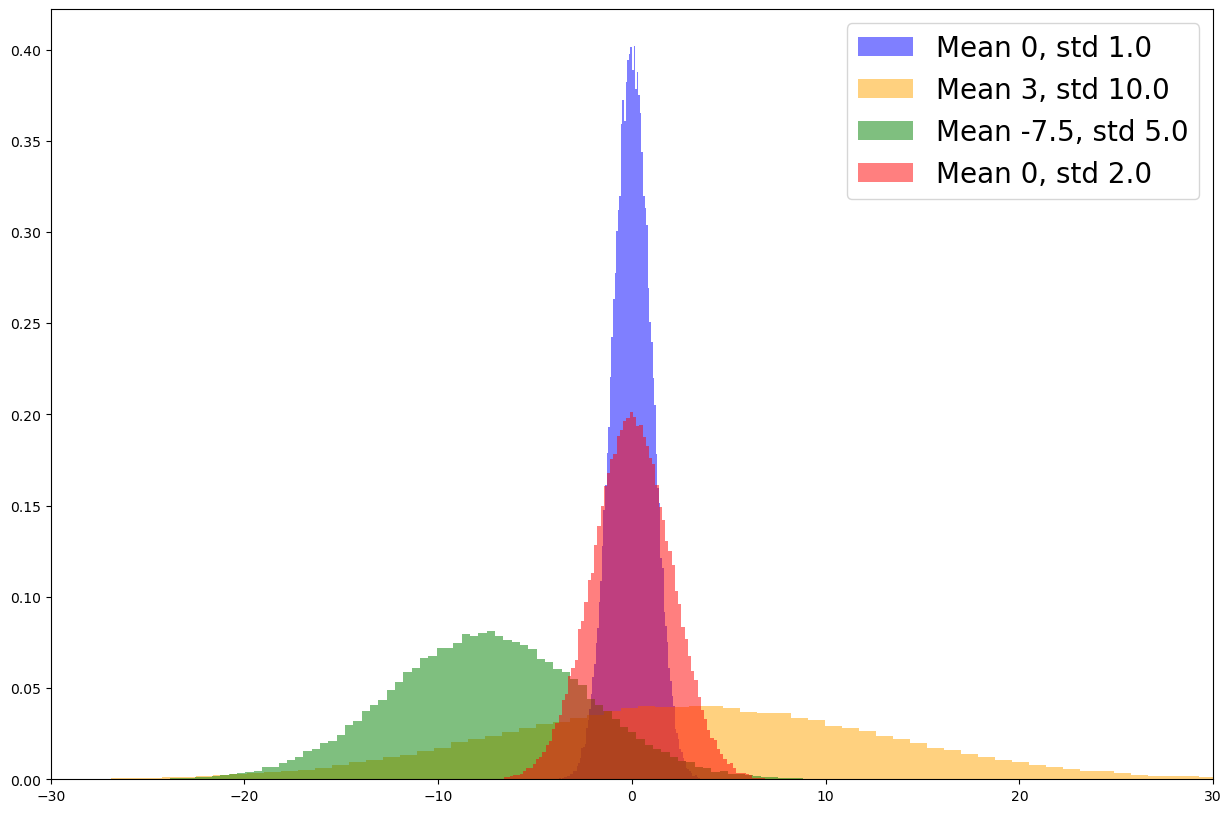

In [4]:
# Let's use numpy to generate samples of gaussian random variables
n_dim, m = 1, 100000
mean1, std1 = 0, 1.
mean2, std2 = 3, 10.
mean3, std3 = -7.5, 5.
mean4, std4 = 0, 2.
v1 = np.random.normal(loc=mean1,  scale=std1, size=(m, n_dim))
v2 = np.random.normal(loc=mean2,  scale=std2, size=(m, n_dim))
v3 = np.random.normal(loc=mean3,  scale=std3, size=(m, n_dim))
v4 = np.random.normal(loc=mean4,  scale=std4, size=(m, n_dim)) 

plt.figure(figsize=(15,10))
plt.hist(v1,density=True,bins=100,color='blue',alpha=0.5, label=f'Mean {mean1}, std {std1}')
plt.hist(v2,density=True,bins=100,color='orange',alpha=0.5, label=f'Mean {mean2}, std {std2}')
plt.hist(v3,density=True,bins=100,color='green',alpha=0.5, label=f'Mean {mean3}, std {std3}')
plt.hist(v4,density=True,bins=100,color='red',alpha=0.5, label=f'Mean {mean4}, std {std4}')
plt.xlim(-30,30), plt.legend(fontsize=20)
plt.show()

# Better code for same plot in the next cell!

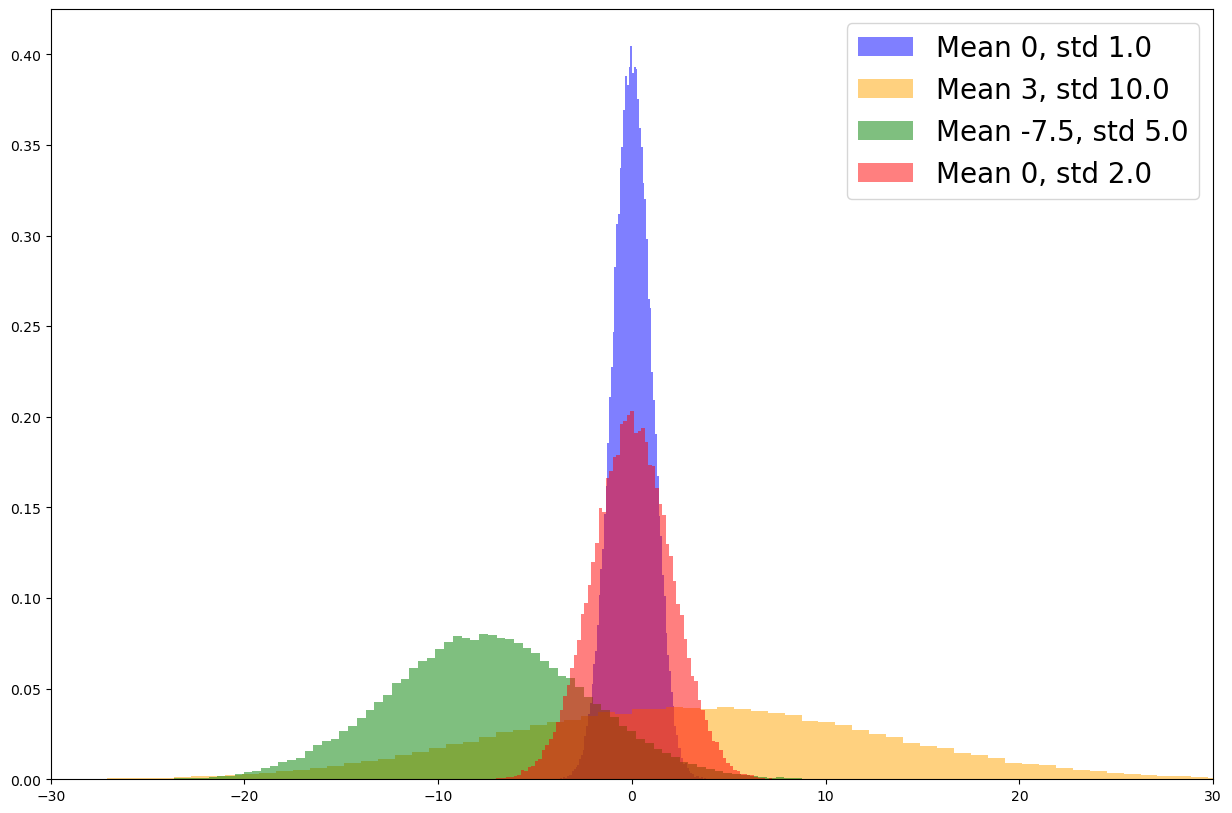

In [5]:
# TODO 2
# Inspect what is inside 'g_vectors', zip(means, stds) and appreciate the code (and possible typos) you saved using
# single line for loops (a.k.a. list comprehensions)
means, stds = [0, 3, -7.5, 0], [1., 10., 5., 2.]
g_vectors = [np.random.normal(loc=mean, scale=std, size=(m, n_dim)) for mean, std in zip(means, stds)]
# Create figure
plt.figure(figsize=(15,10))
colors = ['blue', 'orange', 'green', 'red']
[plt.hist(v,density=True,bins=100,color=c,alpha=0.5, label=f'Mean {m}, std {std}') for m, std, v, c in zip(means, stds, g_vectors, colors)]
plt.xlim(-30,30), plt.legend(fontsize=20)
plt.show()

For now you have seen the *go to* strategy for generating gaussian scalar random variables! Can you generate in a similar way vector valued gaussian random variables?

### How to generate gaussian random vectors of given mean and covariance? 
Say you are given a mean vector $\mu_{new}$ and a covariance matrix $\Sigma_{new}$ (positive semi-definite), how to generate a gaussian random vector with the proper mean and covariance? 

Consider a gaussian random vector $X \in \mathbb{R}^n$ (note that we are using the same notation, capital letters, to denote random variables and vectors of random variables). Once again mean and covariance fully describe the gaussian random vector, from now on let $X \sim \mathcal{N}(\mu, \Sigma)$.
Remember also in this case an affine transformation of a gaussian random vector is a gaussian random vector. 

Therefore the same reasoning we made earlier is applicable here! 

Let's compute mean and covariance of a gaussian random vector after the application of an affine transformation.

__Remark__: The affine transformation now is parametrized by the matrix $A \in \mathbb{R}^{n\times n}$ and the vector $b \in \mathbb{R}^n$: $Y = AX+b$.

From the theory we know $Y$ is a gaussian random variable. It is straightforward to compute its mean (using linearity of the expected value):

$$\mathbb{E}[Y] = A\mathbb{E}[X] + b \qquad \text{(exactly as in the scalar case)}.$$

Now recall the definition of covariance for a vector-valued random variable: $Cov[Y, Y] = \mathbb{E}[(Y-\mathbb{E}[Y])(Y-\mathbb{E}[Y])^T]$. Pay attention to what is happening here: we are multiplying $(Y-\mathbb{E}[Y])\in \mathbb{R}^{n\times 1}$ (column vector) and $(Y-\mathbb{E}[Y])\in \mathbb{R}^{1\times n}$ (row vector), so the result is a $n\times n$ matrix. That is why the covariance $Cov[Y,Y]$ is a $n\times n$ matrix.

Going back to our example:
$$Cov[Y, Y] = \mathbb{E}[(Y-\mathbb{E}[Y])(Y-\mathbb{E}[Y])^T] = \mathbb{E}[(AX+b-A\mathbb{E}[X]-b)(AX+b-A\mathbb{E}[X]-b)^T] = \\ = A \mathbb{E}[(X-\mathbb{E}[X])(X-\mathbb{E}[X])^T]A^T = A Cov[X,X]A^T \in \mathbb{R}^{n\times n}$$

Putting everything together, we have: $Y\sim \mathcal{N}(A\mu +b, A\Sigma A^T)$.

But we still do not know how to generate a gaussian random vector of given mean ($\mu_{new}$) and covariance ($\Sigma_{new}$)!

For the sake of simplicity let's assume we start from a standard gaussian random vector $Z\sim \mathcal{N}(
\mathbf{0},I)$, where $\mathbf{0}$ is a vector of dimension $n$ and $I \in \mathbb{R}^{n\times n}$.
If we apply the affine transformation $Y_{new} = AZ+b$ we get a gaussian with the following distribution $Y_{new} \sim \mathcal{N}(b, A I A^T)$ (where clearly $A I A^T = AA^T$). 

Once again we only need to impose the following equations to hold in order to find the proper affine transformation: 
$\mu_{new} = b$ and $\Sigma_{new} = AA^T$. The first is trivial while the second one might be a little more complicated (we are asking for a matrix A such that the moltiplication by its transpose gives exactly $\Sigma_{new}$). 
Luckily for us we can consider $A$ as the "square root" of $\Sigma$ and find the proper factorization through a very simple linear algebra technique: the spectral theorem (eigenvalue decomposition).

In the case of a real symmetric $n\times n$ matrix, $\Sigma=\Sigma^T$, we all know we can write the eigendecomposition as $\Sigma = Q \Lambda Q^T$ where $Q \in \mathbb{R}^{n \times n}$ can be taken orthonormal (and real) and $\Lambda$ is real. 
But we know $\Sigma$ has another property: it is positive semi-definite! This implies that its eigenvalues are grater or equals to zero ($\Lambda \geq 0$).

These are all the ingredients we need to solve $\Sigma = AA^T$. Indeed if we write the eigenvalue decomposition in an equivalent way we can readily find the proper factorization: $\Sigma= Q\Lambda Q^T = Q \sqrt{\Lambda}\sqrt{\Lambda}Q^T$, where $\sqrt{\Lambda}$ is nothing but the diagonal matrix containing the square root of the $\Lambda$ matrix entries (we can take the square root only thanks to the fact $\Lambda \geq 0$ !). 

If we now define $A=Q\sqrt\Lambda$ we get $\Sigma = Q\sqrt\Lambda (Q\sqrt\Lambda)^T$ and we have solved the problem.

In [6]:
# We choose to use row vectors in place of column vectors (to make you invariant to the notation)
n_dim, m = 2, 100000

# Mean and covariance matrix
mu = np.array([1, 2])
Sigma = np.array([[2, 1],
                  [1, 2]])
# Is Sigma a proper covariance matrix? p.s.d
assert np.array_equal(Sigma, Sigma.T) # symmetric
Lambda, Q = np.linalg.eig(Sigma)      # Have a look at the documentation to see what this function returns
print("Lambda (eigenvalues): ", Lambda, "\n\n", "Q: ", Q)
assert np.all(Lambda >= 0)            # positive semi-definite

# Generate samples from a standard multivariate normal gaussian variable
n = np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim), size=(m))

# Creating the factorization
A = np.matmul(Q, np.diag(np.sqrt(Lambda)))
print("\nA: ", A)
# Applying the affine transformation
x = mu + np.matmul(n, A.T)

# If you are interested, many different factorizations exist. 
# Compare the realizations with the ones computed before: are they identical (w.r.t. the eigenvalues factorization)? 
# L = np.linalg.cholesky(Sigma) # See documentation, Sigma = L L^T
# x = mu + np.matmul(n, L
# )

# What about the empirical average and empirical covariance?  

Lambda (eigenvalues):  [3. 1.] 

 Q:  [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

A:  [[ 1.22474487 -0.70710678]
 [ 1.22474487  0.70710678]]


In [7]:
# Let's compute the empirical average and empirical covariance for the random gaussian vector 
print(f"The sample Mean is \n {x.mean(axis=0)}")
x_centered = x - mu
sample_cov = np.matmul(x_centered.T, x_centered)/m
print(f"The sample Covariance is \n {sample_cov}")

The sample Mean is 
 [0.99375139 1.99622921]
The sample Covariance is 
 [[1.99736832 0.99475779]
 [0.99475779 2.00099657]]


In [8]:
# TODO 3: Try the same as two cells above using gaussian vectors represented as column vectors. 
# Keep all the realizations stored in a numpy array with the following shape: (2, m). This means each random 
# vector is represented as a column random vector and we generate m of them.

# Call the new generated data 'x_new'
### BEGIN SOLUTION
n = np.random.normal(loc=0, scale=1, size=(n_dim, m))
x_new = mu.reshape(-1,1) + np.matmul(A, n)
print(x_new)
### END SOLUTION

[[ 1.10776922 -0.54292782 -0.61266392 ...  1.92744029  0.95885073
   3.23634288]
 [ 3.22859006  2.0953215   1.07748902 ...  4.58659587  1.65862583
   1.97895074]]


In [9]:
assert x_new.shape == (n_dim, m)
x_centered_new = x_new - mu.reshape(-1,1)
sample_cov_new = np.matmul(x_centered_new, x_centered_new.T)/m
assert np.isclose(np.abs(sample_cov_new-sample_cov).sum(), 0, atol=0.3)

In [10]:
# TODO 4
# Create a function to check if a matrix is symmetric and p.s.d.
def check_psd(A):
    ''' Function to check whether a matrix is psd or not
    :param A: n \times n matrix stored as a numpy array
    :return is_psd: Boolean representing whether the matrix is or is not a psd matrix
    '''
    ### BEGIN SOLUTION
    if np.abs((A-A.T)).sum() != 0.:
        return False
    L, V = np.linalg.eig(A)
    if not (L >= 0.).all():
        return False
    return True
    ### END SOLUTION

In [11]:
assert check_psd(Sigma)
x_centered_new = x_new - mu.reshape(-1,1)
Sigma_hat = np.matmul(x_centered_new, x_centered_new.T)/m
assert np.isclose(np.abs(Sigma_hat - Sigma).mean(), 0., atol=0.1)

### BEGIN HIDDEN TESTS
assert check_psd(np.zeros((10,10)))
assert check_psd(np.ones((10,10)))
A = np.random.normal(0,1., (5,5))
assert check_psd(np.matmul(A, A.T))
### END HIDDEN TESTS

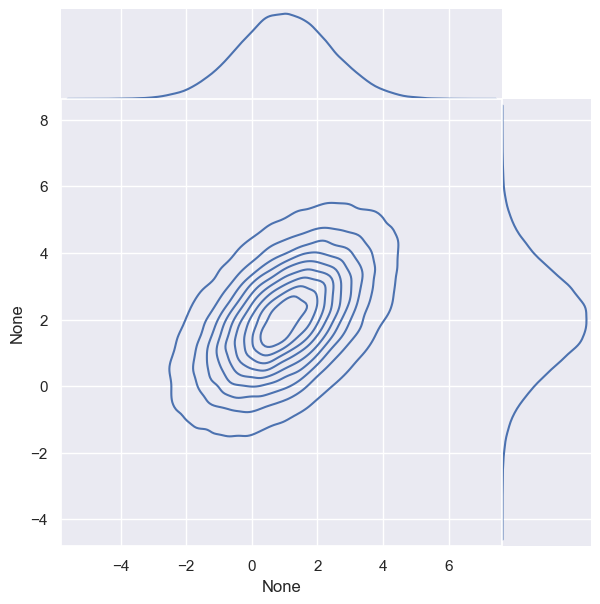

In [12]:
# Now we will visualize the two dimensional gaussian random variable we have generated using seaborn
import seaborn as sns; 
sns.set()
sns.jointplot(x=x[:,0],
              y=x[:,1], 
              kind="kde", # stands for kernel density estimate
              space=0)

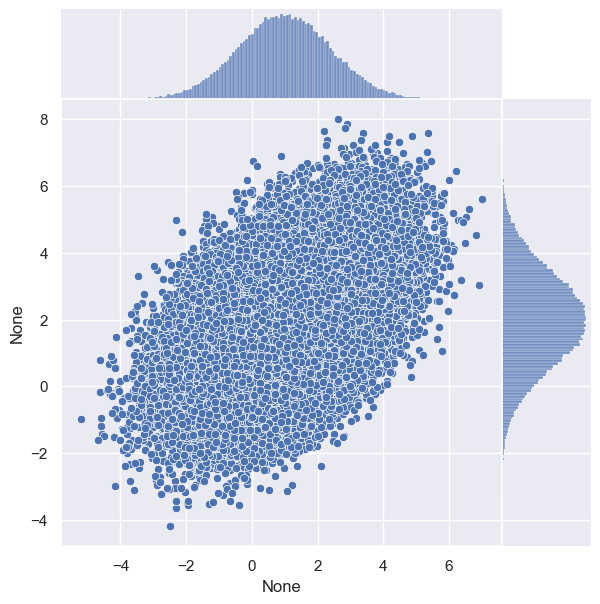

In [13]:
sns.set()
sns.jointplot(x=x[:,0],
              y=x[:,1], 
              space=0)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]] 

 [3. 1.] 

 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


((-6.717674978384595,
  8.717674978384595,
  -5.717674978384597,
  9.717674978384597),
 <matplotlib.legend.Legend at 0x13c702c6810>)

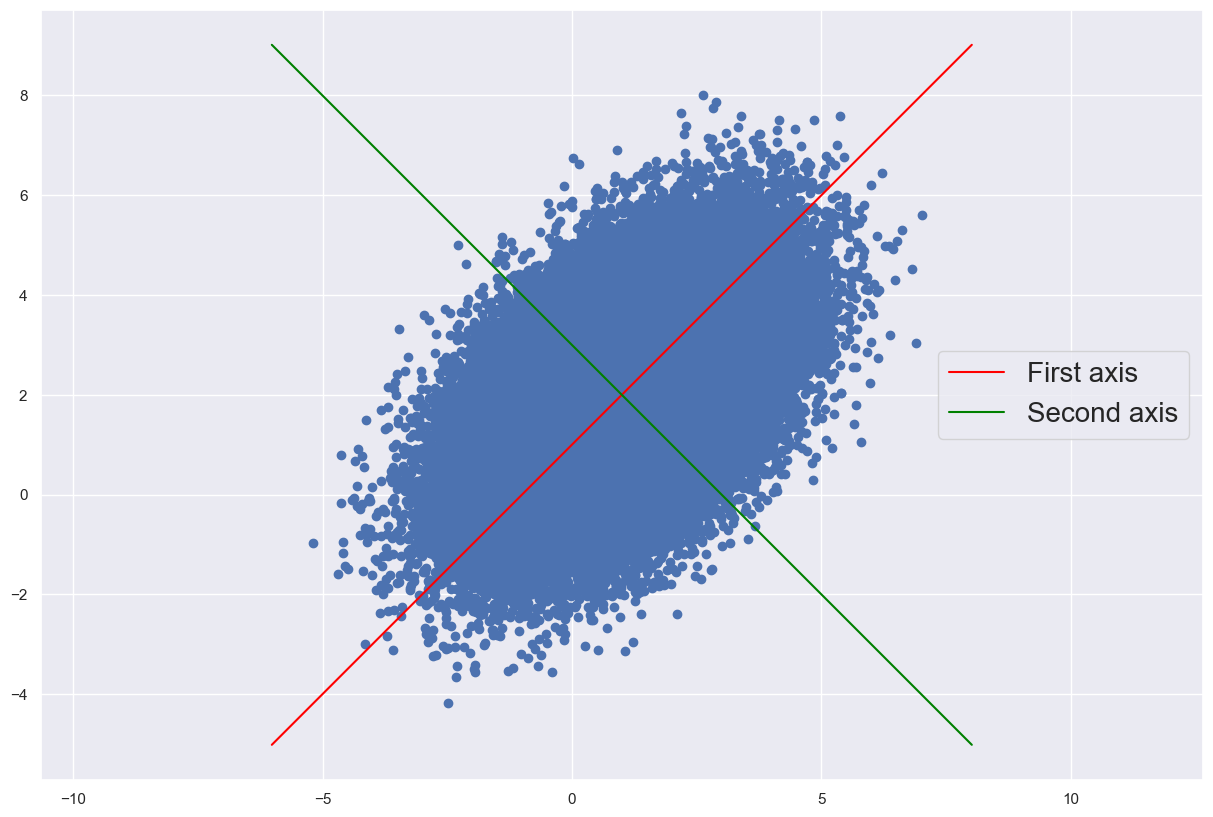

In [20]:
# Let's show scatter plot with directions given by the covariance matrix
U, S, V_transpose = np.linalg.svd(Sigma)   # have a look at the documentation (you will need it in future labs)
print(U, "\n\n", S, "\n\n", V_transpose)
plt.figure(figsize=(15, 10))
plt.scatter(x[:,0], x[:,1])

def plot_line(direction, center, x_lims, color, label):
    x = np.linspace(x_lims[0], x_lims[1], 1000)
    if direction[0] != 0:
        y = direction[1] / direction[0] * x
    else:
        y = np.linspace(x_lims[0], x_lims[1], 1000)
        x = np.zeros_like(y)
    plt.plot(x + center[0], y + center[1], color=color, label=label)

max_value = np.abs(x).max(axis=0)[0]
plot_line(U[:,0], mu, [-max_value, max_value], color='red', label='First axis')
plot_line(U[:,1], mu, [-max_value, max_value], color='green', label='Second axis')
plt.axis('equal'), plt.legend(fontsize=20)
# Each axis std is given np.sqrt(S)

In [22]:
# TODO 5 (answer in the following cell)
# Have a look at the documentation of svd.
# Compare U and V, what do you observe? Try to get Sigma back from U,S,V
U, S, V_transpose = np.linalg.svd(Sigma)

In [23]:
### BEGIN SOLUTION
Sigma_recovered = np.matmul(np.matmul(U, np.diag(S)), V_transpose)
assert np.isclose(Sigma_recovered, Sigma).all()
### END SOLUTION

In [24]:
# TODO 6 (answer in the following cell)
# What if you do not know the true covariance matrix? Can you estimate its spectrum and eigenvectors using data?
U_x, S_x, V_x_transpose = np.linalg.svd(x_centered / np.sqrt(m), full_matrices=False)
# Compare U_x with U and V_x with V, what do you observe? 
# Can you build the sample covariance matrix only from S_x and V_x? How?
# Is this a smart way to compute the sample covariance? If not, why (try with more data)?

Recall that the empirical covariance matrix is $\hat{\Sigma} = \frac{(X - \mu)^T}{\sqrt{m}} \frac{(X - \mu)}{\sqrt{m}}$, where $X \in \mathbb{R}^{m \times d}$, and that $\frac{(X - \mu)}{\sqrt{m}} = U_x S_x V_x^T$.

Therefore
\begin{equation}
\begin{aligned}
\hat{\Sigma} &= \frac{(X - \mu)^T}{\sqrt{m}} \frac{(X - \mu)}{\sqrt{m}} \\
             &= (U_x S_x V_x^T)^T (U_x S_x V_x^T) \\
             &= V_x S_x^2 V_x^T
\end{aligned}
\end{equation}

This is *not* a smart way to compute the sample covariance, as we are computing the SVD of a large matrix $\in \mathbb{R}^{m \times d}$, which is computationally expensive.

In [26]:
### BEGIN SOLUTION

# check the shapes
print(U_x.shape)
print(U.shape)
print(V_x_transpose.shape)
print(V_transpose.shape)


sample_cov_recovered =  np.matmul( np.matmul(V_x_transpose.T, np.diag(np.square(S_x))), V_x_transpose)
assert np.isclose(sample_cov_recovered, sample_cov).all()
### END SOLUTION

(100000, 2)
(2, 2)
(2, 2)
(2, 2)


# Generalization vs training error

In this section we are going to compare the generalization error and the training error in the most simple scenario you can imagine: scalar Least Squares using a linear model class.

__Note__: Since we want to make things as clear as possible, we are going to be very pedantic and emphasise the difference between a random variable and its realizations.
We are going to use the underbar to denote a random variable. Therefore the notation is as follows: $\underline y$ is a random variable (say a Gaussian, a Bernoulli, Chi-square, ...) and $y$ is its realization, which is a number (say 1.2, 10.0, 99.032, ...).

To begin with, we will setup the notation and the main assumptions we need in order to perform all the necessary computations. We are going to compute integrals which might not have closed form solutions! That is why we need some assumptions.

We are going to compute the integral to get the generalization error for a simple model class, the scalar linear models:
$$\mathcal{H}_{lin} := \{x \mapsto wx : w\in \mathbb{R}\}$$
in the case of squared loss.

We are interested in comparing the following quantities:

$$L_\mathcal{D}(h) := \mathbb{E}_\mathcal{D}[l(\underline y, h(\underline x))] := \int l( y, h( x)) p( x,  y) dx dy \quad \longrightarrow \quad \text{this is a number}$$ 

$$L_\mathcal{S}(h) := \frac{1}{m} \sum_{i=1}^{m} l(y_i, h(x_i)) \quad \longrightarrow \quad \text{this is a number: a realization of the following random variable}$$

$$\underline{L_\mathcal{S}(h)}:= \frac{1}{m} \sum_{i=1}^{m} l(\underline y_i, h(\underline x_i)) \quad \longrightarrow \quad \text{this is a random variable}$$

where $l$ is a loss funtion (a deterministic function), $h \in \mathcal{H}$ and $\mathcal D$ is the joint distribution of $\underline y$ and $\underline x$ (outputs and inputs to our models). 

In the following exercise we will need to define what we mean by each ones of these quantities.

1. Let's start by defining what is the data generative model $\mathcal D$: you can think of it as the object Dice in the previous lab (it describes the random variables which are generating all the data we see). We need to specify the joint distribution of $\underline x$ and $\underline y$: $p(x, y)$. Remember we can write the joint probability of two general random variables using conditional probabilities, so that we have: $p(x, y)=p(y|x)p(x)$. Don't forget $p(y|x)$ describes a random variable on $\underline y$, while $x$ is to be considered as a fixed number (you can think of it as an outcome)! Up to now everything is super general, so let's introduce some assumption in order to make our lives easier. We will assume $\underline x\sim \mathcal{N}(\mu_x, \sigma_x^2)$, and $p( y| x)\sim \mathcal{N}(a x, \sigma^2)$. Note here the mean of $\underline y$ depends on the outcomes $x$. How to generate samples from $\underline y$? Take $\underline x$, sample it, get a number, say $ x=1.234$, and now generate a sample from a gaussian random variable whose mean is $a * 1.234$ and whose variance is $\sigma^2$.

Why did I choose such a strange $p( x, y)$? You can prove such a joint distribution is derived from the following very simple model: 
$$\underline y := a \underline x + \underline e$$
where $\underline e \sim \mathcal N (0, \sigma^2)$ and $\underline x$ is independent from $\underline e$.



__TODO__: Do the computations and show the distribution of $\underline y$ is $\mathcal N (a\mu_x, a^2 \sigma^2_x + \sigma^2)$.

2. We will adopt the squared loss, i.e. $l(b, c) := (b-c)^2$.

3. We will choose our model class to be the set of scalar linear models, $\mathcal{H}_{lin} := \{x \mapsto wx : w\in \mathbb{R}\}$


__Generalization error computation__: In this very simple case we can actually compute the generalizaiton error by hand (solving the integral in the definition). If you want you can compute the integral using the densities... but I prefer to save some time and use the properties of the expected value. Therefore, replacing the definition of $l(b, c) := (b-c)^2$ and $\underline y$ inside the one of the generalization error, recalling the basic relation $var[\underline y] = \mathbb{E}[\underline y^2] - \mathbb{E}[\underline y]^2$ and using the fact that $\underline x$ and $\underline e$ are independent (and therefore $\mathbb{E}[\underline x \underline e] = \mathbb{E}[\underline x] \mathbb{E}[\underline e] = 0$) we get:

\begin{align}
L_\mathcal D (h) &= \mathbb{E}_{\underline x, \underline y}[(\underline y - h(\underline x))^2] = \mathbb{E}_{\underline x, \underline e}[(a\underline x + \underline e - w\underline x)^2] \\ 
&= \mathbb{E}_{\underline x, \underline e}[((a-w)\underline x + \underline e)^2] = \mathbb{E}_{\underline x, \underline e}[(a-w)^2\underline x^2 + 2 \underline x \underline e + \underline e^2 ] \\
&= (a-w)^2\mathbb{E}_{\underline x}[\underline x^2]+\mathbb{E}_{\underline e}[\underline e^2] = (a-w)^2(var[\underline x]+\mathbb{E}_{\underline x}[\underline x]^2)+(var[\underline e]+\mathbb{E}_{\underline e}[\underline e]^2) \\
&=(a - w)^2(\sigma_x^2 + \mu_x^2)+\sigma^2\\
\end{align}

Boring, but easy! 

In the following you will implement a function to compute $L_\mathcal D (h)$ (I am using the word "computing" and not "approximating" here, so you should use the formula we just derived!) and a simple class to represent the joint probability of $\underline x$ and $\underline y$.

In [27]:
# TODO 7: Write the class method generate_samples in order to get samples from the joint distribution (x,y)
class D():
    def __init__(self, mean_x, var_x, var_e, a):
        self.mean_x, self.var_x = mean_x, var_x
        self.var_e = var_e
        self.a = a
        
    def generate_samples(self, m : int) -> np.ndarray:  # -> specifies the type of the output but is ignored by the compiler
        '''
        Function to generate outcomes of the joint distribution p(x,y) described in the cell above
        
        :param m: Number of measurements
        :returns: a tuple containing both outcomes from x and from y 
            WHERE:
            :x: is a numpy vector of dimension (1, m) containing the outcomes of x 
            :measurements: is a numpy vector of dimension (1, m) containing the outcomes of y
        '''
        ### BEGIN SOLUTION
        x = self.mean_x + np.sqrt(self.var_x) * np.random.normal(size=(1, m))
        e = np.sqrt(self.var_e) * np.random.normal(size=(1, m))
        measurements = self.a * x + e
        ### END SOLUTION
        return x, measurements

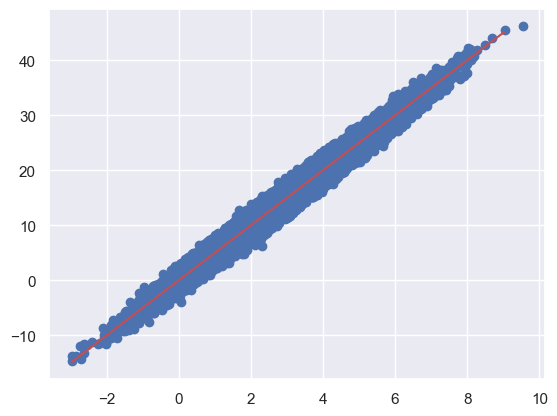

In [43]:
mean_x, var_x, var_e, a = 3, 2, 1, 5
joint_distr = D(mean_x=mean_x, var_x=var_x, var_e=var_e, a=a)
m = 100000
measurements = joint_distr.generate_samples(m)
plt.scatter(measurements[0].reshape(-1,1), measurements[1][:].reshape(-1,1))
plt.plot(np.arange(measurements[0].reshape(-1,1).min(), measurements[0].reshape(-1,1).max()), a*np.arange(measurements[0].reshape(-1,1).min(), measurements[0].reshape(-1,1).max()), c = "r")

In [29]:
assert measurements[0].shape == (1, m)
assert measurements[1].shape == (1, m)

### BEGIN HIDDEN TESTS
assert np.isclose(measurements[0].mean(), mean_x, atol=0.1)
assert np.isclose(measurements[0].var(), var_x, atol=0.1)
assert np.isclose(measurements[1].mean(), a * mean_x, atol=0.1)
assert np.isclose(measurements[1].var(), a**2 * var_x + var_e, atol=0.6)
### END HIDDEN TESTS

In [30]:
# TODO 8: write a function to compute the generalization error (using the formula we derived in the cell above!)
def compute_generalization_error(a, w, mu_x, sigma_x_2, sigma_2):
    '''
    This function assumes all its inputs but w are scalars, in the case w is a vector this function should be 
    implemented such that it returns a vector of generalization errors for each value in the array w. 
    SUGGESTION: Try to implement this function as all its inputs (w too) were scalars, then try to feed a numpy vector 
    and see what happens (this is the magic of Numpy!)
    '''
    ### BEGIN SOLUTION
    gen_error = sigma_2 + (mu_x**2 + sigma_x_2) * (a - w)**2
    ### END SOLUTION
    return gen_error

In [31]:
assert compute_generalization_error(a, a, mean_x, var_x, var_e) == var_e
assert compute_generalization_error(a, 0.123, mean_x, var_x, var_e) == 262.636419
w_vector = np.linspace(-5, 15, 1000)
assert compute_generalization_error(a, w_vector, mean_x, var_x, var_e).shape == w_vector.shape

Text(0.5, 0, 'w parameter')

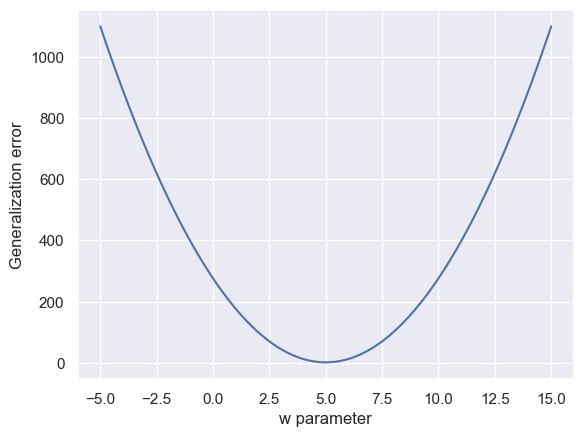

In [44]:
# Let's plot the generalization error
w_possible = np.linspace(-5, 15, 1000)
generalization_error = compute_generalization_error(a, w_possible, mean_x, var_x, var_e)
plt.plot(w_possible, generalization_error)
plt.ylabel('Generalization error')
plt.xlabel('w parameter')

__TODO 9__:

What do you observe? What is the shape you get? Why? Which is the best parameter you could possibly choose? 

## Least Squares

By definition, the Least Squares method finds the optimal parameter values $w$ for a given model class by minimizing the sum of squared residuals $R$, given by:

$$R(w) = \sum_{i=1}^m r_i^2, \qquad \text{where} \quad r_i(w) = y_i - h_w(x_i)$$

Note that under the assumption of a linear model class, the residuals above can be specified as $r_i(w) = y_i - wx_i$. We can easily see that under the assumption of the squared loss, we have $r_i^2(w) = l(y_i, h_w(x_i))$, so that:
$$ \frac{1}{m}R(w) = L_\mathcal{S}(h_w) $$

Therefore the Least Squares method is actually equivalent to the empirical risk minimization with respect to the given data:

$$\begin{align}
    w_{LS} &= min_w[L_\mathcal{S}(h_w)] \\
    &= min_w \left\{ \frac{1}{m} \sum_{i=1}^m(y_i - wx_i)^2 \right\}
\end{align}$$

The stationary points of the objective can be found by imposing the derivative of the objective equal to zero:

$$\frac{\partial L_\mathcal{S}(h_w)}{\partial w} = 0 \\ \implies \frac{\partial}{\partial w} \left[ \frac{1}{m} \sum_{i=1}^m(y_i - wx_i)^2 \right] =0$$

You should know ho to go on from this point onward!

*Hint: For the scalar case the solution is trivial. You can start from there. Of course the vectorial case is more general!*

In [45]:
# TODO 10:
# Now write a simple function to compute the empirical loss of given a parameter w and the m scalar realizations x and y
def empirical_training_loss(w, x, y) -> np.ndarray:
    '''
    Function to compute the empirical squared loss (if you give more than one scalar parameters, say p, it will compute the
    empirical loss for each scalar parameter).
    :param w: a scalar or numpy array of shape (p, 1)
    :param x: a numpy vector of shape (1, m) representing the input x 
    :param y: a numpy vector of shape (1, m) representing the output y 
    
    :returns: numpy array. of shape (p, 1) containing the empirical loss computed for each scalar parameter in the 
              vector w 
    '''
    ### BEGIN SOLUTION
    empirical_loss = ((y - w * x)**2).mean(axis=1)
    ### END SOLUTION
    return empirical_loss

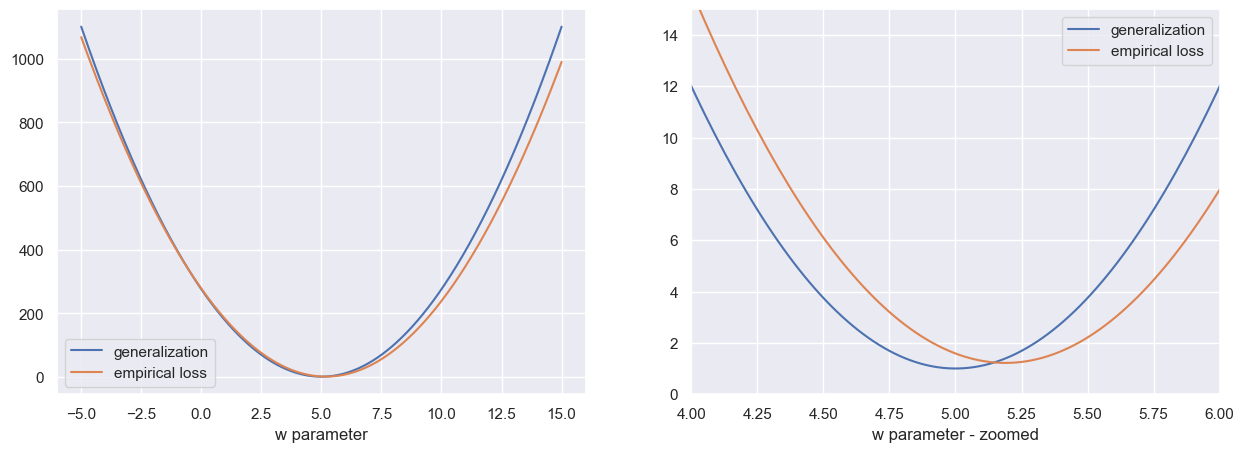

In [46]:
measurements = joint_distr.generate_samples(10)
empirical_loss = empirical_training_loss(w_possible.reshape(-1,1), measurements[0], measurements[1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(w_possible, generalization_error, label='generalization')
axes[0].plot(w_possible, empirical_loss, label='empirical loss')
axes[0].set_xlabel('w parameter')
axes[0].legend()

axes[1].plot(w_possible, generalization_error, label='generalization')
axes[1].plot(w_possible, empirical_loss, label='empirical loss')
axes[1].set_xlim(4,6)
axes[1].set_ylim(0,15)
axes[1].set_xlabel('w parameter - zoomed')
axes[1].legend()

In [47]:
# TODO 11: Write a function to compute the LS solution to a scalar LS problem. 
def compute_ls_solution(y, x) -> np.float64:
    '''
    Function that implements scalar LS solution given data x (inputs) and y (outputs)
    
    :param x: numpy vector of shape (1, m) representing inputs x
    :param y: numpy vector of shape (1, m) representing outputs y
    
    :returns: scalar parameter w_hat solution to the ERM problem
    '''
    ### BEGIN SOLUTION
    w_hat = (x*y).sum() / (x*x).sum()
    ### END SOLUTION
    return w_hat

(0.0, 15.0)

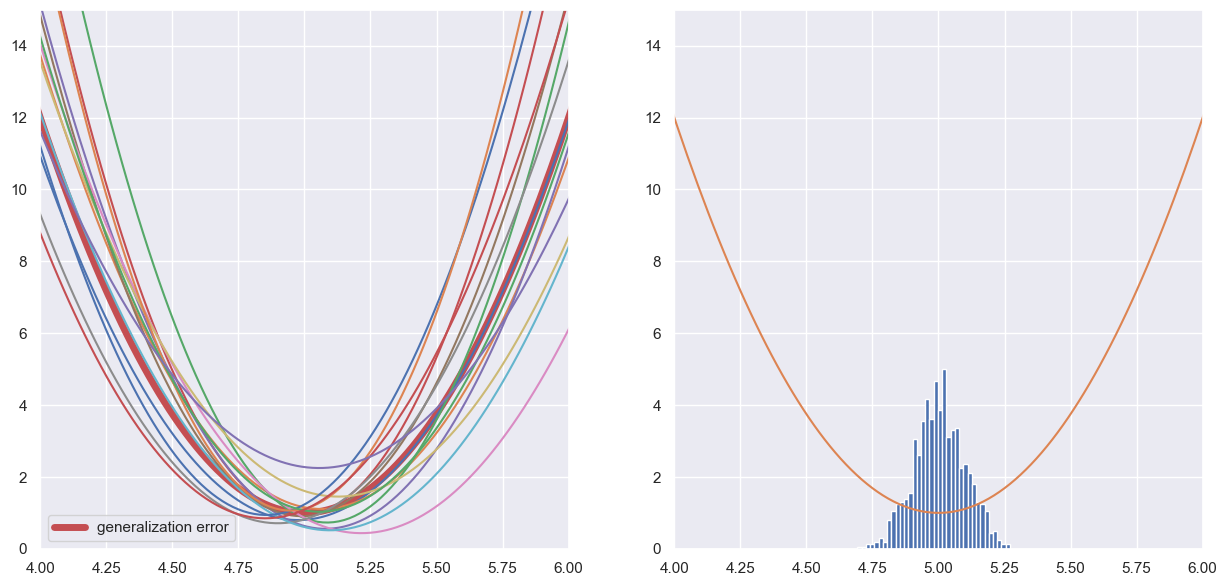

In [48]:
# TODO 12: Complete the following code. We are generating different measurements from our joint distribution 
# and comparing them to the generalization. Moreover for each empirical loss realization we compute its minimizer.
# We use an histogram to see the distribution of optimizers we can achieve when we sample a different training sets.
# Question: play with m to see how the empirical loss changes and how the corresponding w_opt changes. What do you 
# observe?

T_estimates = 1000
m = 10
w_opt_realizations = []

fig, axes = plt.subplots(1,2,figsize=(15,7))
axes[0].plot(w_possible, generalization_error, linewidth=5, color='r', label='generalization error')

for t in range(T_estimates): 
    # Generate the training dataset, composed by realizations from the joint distribution of x and y
    x, y = None, None
    ### BEGIN SOLUTION
    x, y = joint_distr.generate_samples(m)
    ### END SOLUTION
    
    # Evaluate the empirical loss
    empirical_loss = None
    ### BEGIN SOLUTION
    empirical_loss = empirical_training_loss(w_possible.reshape(-1,1), x, y)
    ### END SOLUTION
    
    # Get the optimal ERM w_opt
    w_opt = None
    ### BEGIN SOLUTION
    w_opt = compute_ls_solution(y, x)
    ### END SOLUTION
    
    w_opt_realizations.append(w_opt)
    if t < 15: # To avoid clutter in the plot
        axes[0].plot(w_possible, empirical_loss)

axes[0].set_xlim([4,6])
axes[0].set_ylim([0,15])  
axes[0].legend()

bins = np.linspace(2, 10, 500)
axes[1].hist(w_opt_realizations, bins, density=True)
axes[1].plot(w_possible, generalization_error)
axes[1].set_xlim([4,6])
axes[1].set_ylim([0,15])

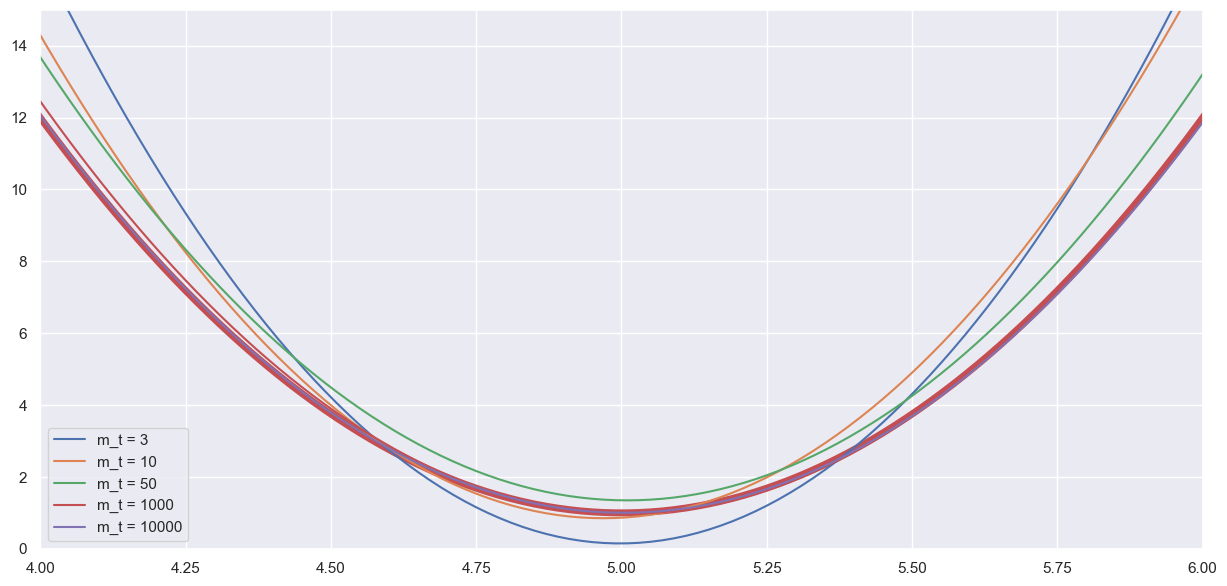

In [49]:
# TODO 13: We now will increase the number of data in the training datset and see what happens to the empirical loss.
# What do you observe?

Ns = [3, 10, 50, 1000, 10000]

fig, axes = plt.subplots(1,1,figsize=(15,7))
axes.plot(w_possible, generalization_error, linewidth=5, color='r')
x, y = joint_distr.generate_samples(Ns[-1])
for m_t in Ns:  
    x_train, y_train = x[0, :m_t], y[0, :m_t]
    empirical_loss = empirical_training_loss(w_possible.reshape(-1,1), x_train, y_train)
    w_opt_realizations.append(compute_ls_solution(y_train, x_train))
    axes.plot(w_possible, empirical_loss, label=f'm_t = {m_t}')

axes.set_xlim([4,6])
axes.set_ylim([0,15])
axes.legend()

In [50]:
# TODO 14: Write a function to compute the optimal LS solution in vector notations. Assume X^TX is invertible 
def vector_LS_solution(X : np.ndarray, Y : np.ndarray) -> np.ndarray:
    '''
    Assuming X^TX is invertible this functions returns the optimal parameters of a LS problem for which the parameters
    are vectors.
    :parameters X: input data matrix of shape (m, p)
    :parameters Y: output data array of shape (m, 1)
    
    :returns: optimal w_opt solution of the LS problem (its shape is (p, 1))
    '''
    ### BEGIN SOLUTION
    inverse = np.linalg.inv(np.matmul(X.T, X))
    w_hat = np.matmul(inverse, np.matmul(X.T, Y))
    ### END SOLUTION
    return w_hat

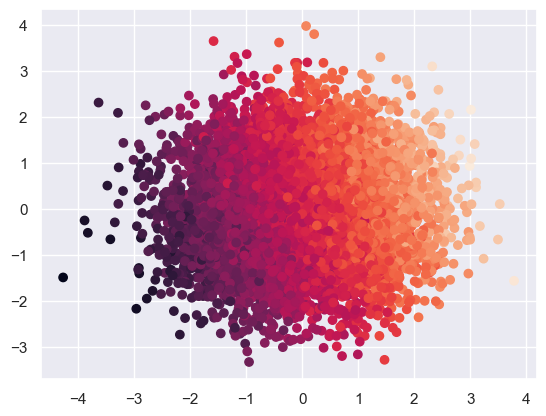

In [74]:
X = np.random.normal(size=(10000, 2))
A = np.array([[3],[1]]).reshape(-1,1)
E = np.random.normal(size=(10000, 1))
Y = np.matmul(X, A) + E
plt.scatter(X[:,0], X[:,1], c=Y[:,0])

In [75]:
assert vector_LS_solution(X, Y).shape == (2,1)
### BEGIN HIDDEN TESTS
def vector_LS_solution_sol(X : np.ndarray, Y : np.ndarray) -> np.ndarray:
    inverse = np.linalg.inv(np.matmul(X.T, X))
    return np.matmul(inverse, np.matmul(X.T, Y))
assert np.isclose(vector_LS_solution(X, Y), vector_LS_solution_sol(X, Y)).all()
### END HIDDEN TESTS

In [76]:
# What do you observe? Why?
vector_LS_solution(X, Y)

array([[3.00610797],
       [0.99318605]])